In [1]:
import Graph
import pandas as pd
import json
from ast import literal_eval
import networkx as nx
from tqdm import tqdm
import WordPreprocessing
import math
import community
s=WordPreprocessing.sentence()

In [2]:
def add_movie_topic(g,key,movie_topic):
    g=nx.Graph(g)
    for i,m_title in enumerate(key):
        # if i==1: break
        split_title = m_title.split('_')[0]
        for k,v in movie_topic[m_title].items():
            g.add_weighted_edges_from([(split_title,k,v)])
            # print(k,v)
    return g
    

In [3]:
def topic_title(g,mbti):
    topic = pd.read_csv('./final_mbti_topic.csv',index_col=0)
    intesection = list((set(topic.index) & set(g.nodes)))
    topic = topic.loc[intesection]
    topic = list(topic[f'{mbti}'].dropna().index)

    title=pd.read_csv('./EndData/total_review_end.csv',index_col=0)['title']

    with open(f'./EndData/final_topic_scaled.json', 'r') as f:
        movie_topic = json.load(f)
        key = list(movie_topic.keys())

    return topic,title,key,movie_topic

In [4]:
def add_node_edge(g,model,topic,key,movie_topic):
    sub = nx.Graph(g)
    w=0
    l=[]
    for topic1 in tqdm(topic):
        for k in key:
            for topic2 in list(movie_topic[k]):
                try:
                    w=model.similarity(topic1,topic2)
                except:
                    continue
                if 0.7<w:
                    try:
                        sub[topic2]
                    except:
                        l.append([topic1,topic2,w])
                        sub.add_weighted_edges_from([(topic1,topic2,w)])
    return sub
                                        


In [5]:
def remove_edge(g,topic,key,model):  
    sub = nx.Graph(g)
    w=0
    l=[]
    for topic1 in tqdm(topic):
        for k in key:
            for topic2 in list(movie_topic[k]):
                try:
                    w=model.similarity(topic1,topic2)
                except:
                    continue
                if w<0.8:
                    l.append([topic1,topic2,w])
                    try:
                        sub.remove_edge(topic1,topic2)
                        # sub.remove_node(topic2)
                    except:
                        continue
    return sub

In [6]:
def recommender(g,topic,title,mbti,model):
    dic = {}
    for n,ti in tqdm(enumerate(list(title))):
        # if n==10: break
        weight = []
        for k in topic:
            w=0
            c=1
            try:
                d = nx.shortest_path(g,source=k,target=ti,weight='distance')
            except:
                continue
            for i in range(0,len(d)-1):
                try:

                    w += round(model.similarity(f'{k}',str(d[i+1])),4)
                    # w1 = round(model.similarity(str(d[i]),str(d[i+1])),4)
                    # w2 = g[d[i]][d[i+1]]['weight']*10
                    # w = w/w1+w/w2
                    # weight1 = 1-round(model.distance(f'{k}',str(d[i+1])),1)
                    # weight1 = round(model.distance(str(d[i]),str(d[i+1])),1)
                    
                    # weight1 = g[d[i]][d[i+1]]['weight']
                    # weight2 = 1-round(model.distance(str(d[i]),str(d[i+1])),1)
                        
                    # w = (w*weight2) + (weight1*w)
                    # print(w,w1, w2)
                    # w = (weight1*w)
                    # c +=1
                except:
                    w +=0
                c+=1
            weight.append(round(w/c,4))
        try:
            dic[ti]=max(weight)
        except:
            continue
    return dic

In [7]:
mbti_list = ['ISTJ','ISFJ','INFJ','INTJ',
                        'ISTP','ISFP','INFP','INTP',
                        'ESTP','ESFP','ENFP','ENTP',
                        'ESTJ','ESFJ','ENFJ','ENTJ']

In [ ]:
for mbti in mbti_list:
    print(mbti)
    gm = Graph.MakeGraph(mbti_data=1)
    en1 = gm.load_graph(f'./network/graph/ori_{mbti}_Network_2')
    fi1 = gm.filter_entity_graph(en1,weight=0.01)
    topic,title,key,movie_topic = topic_title(fi1,f'{mbti}')
    model = gm.load_model('./network/fullnetwork/full_model')
    print('movie topic add')
    sub = add_movie_topic(fi1,key,movie_topic)
    # print('full graph add')
    # sub = add_node_edge(fi1,model,topic,key,movie_topic)
    gm.save_graph(sub,f'./network/final_graph/sample2/{mbti}')
    model = gm.model(sub,d=128,w=10)
    gm.save_model(model,f'./network/model/sample2/{mbti}')
# dic = recommender(sub2,title,'INTJ',model)
# s.top_n(dic,True,20)

In [68]:
c = gm.make_community(g)
print(len(list(c.index)))

3874


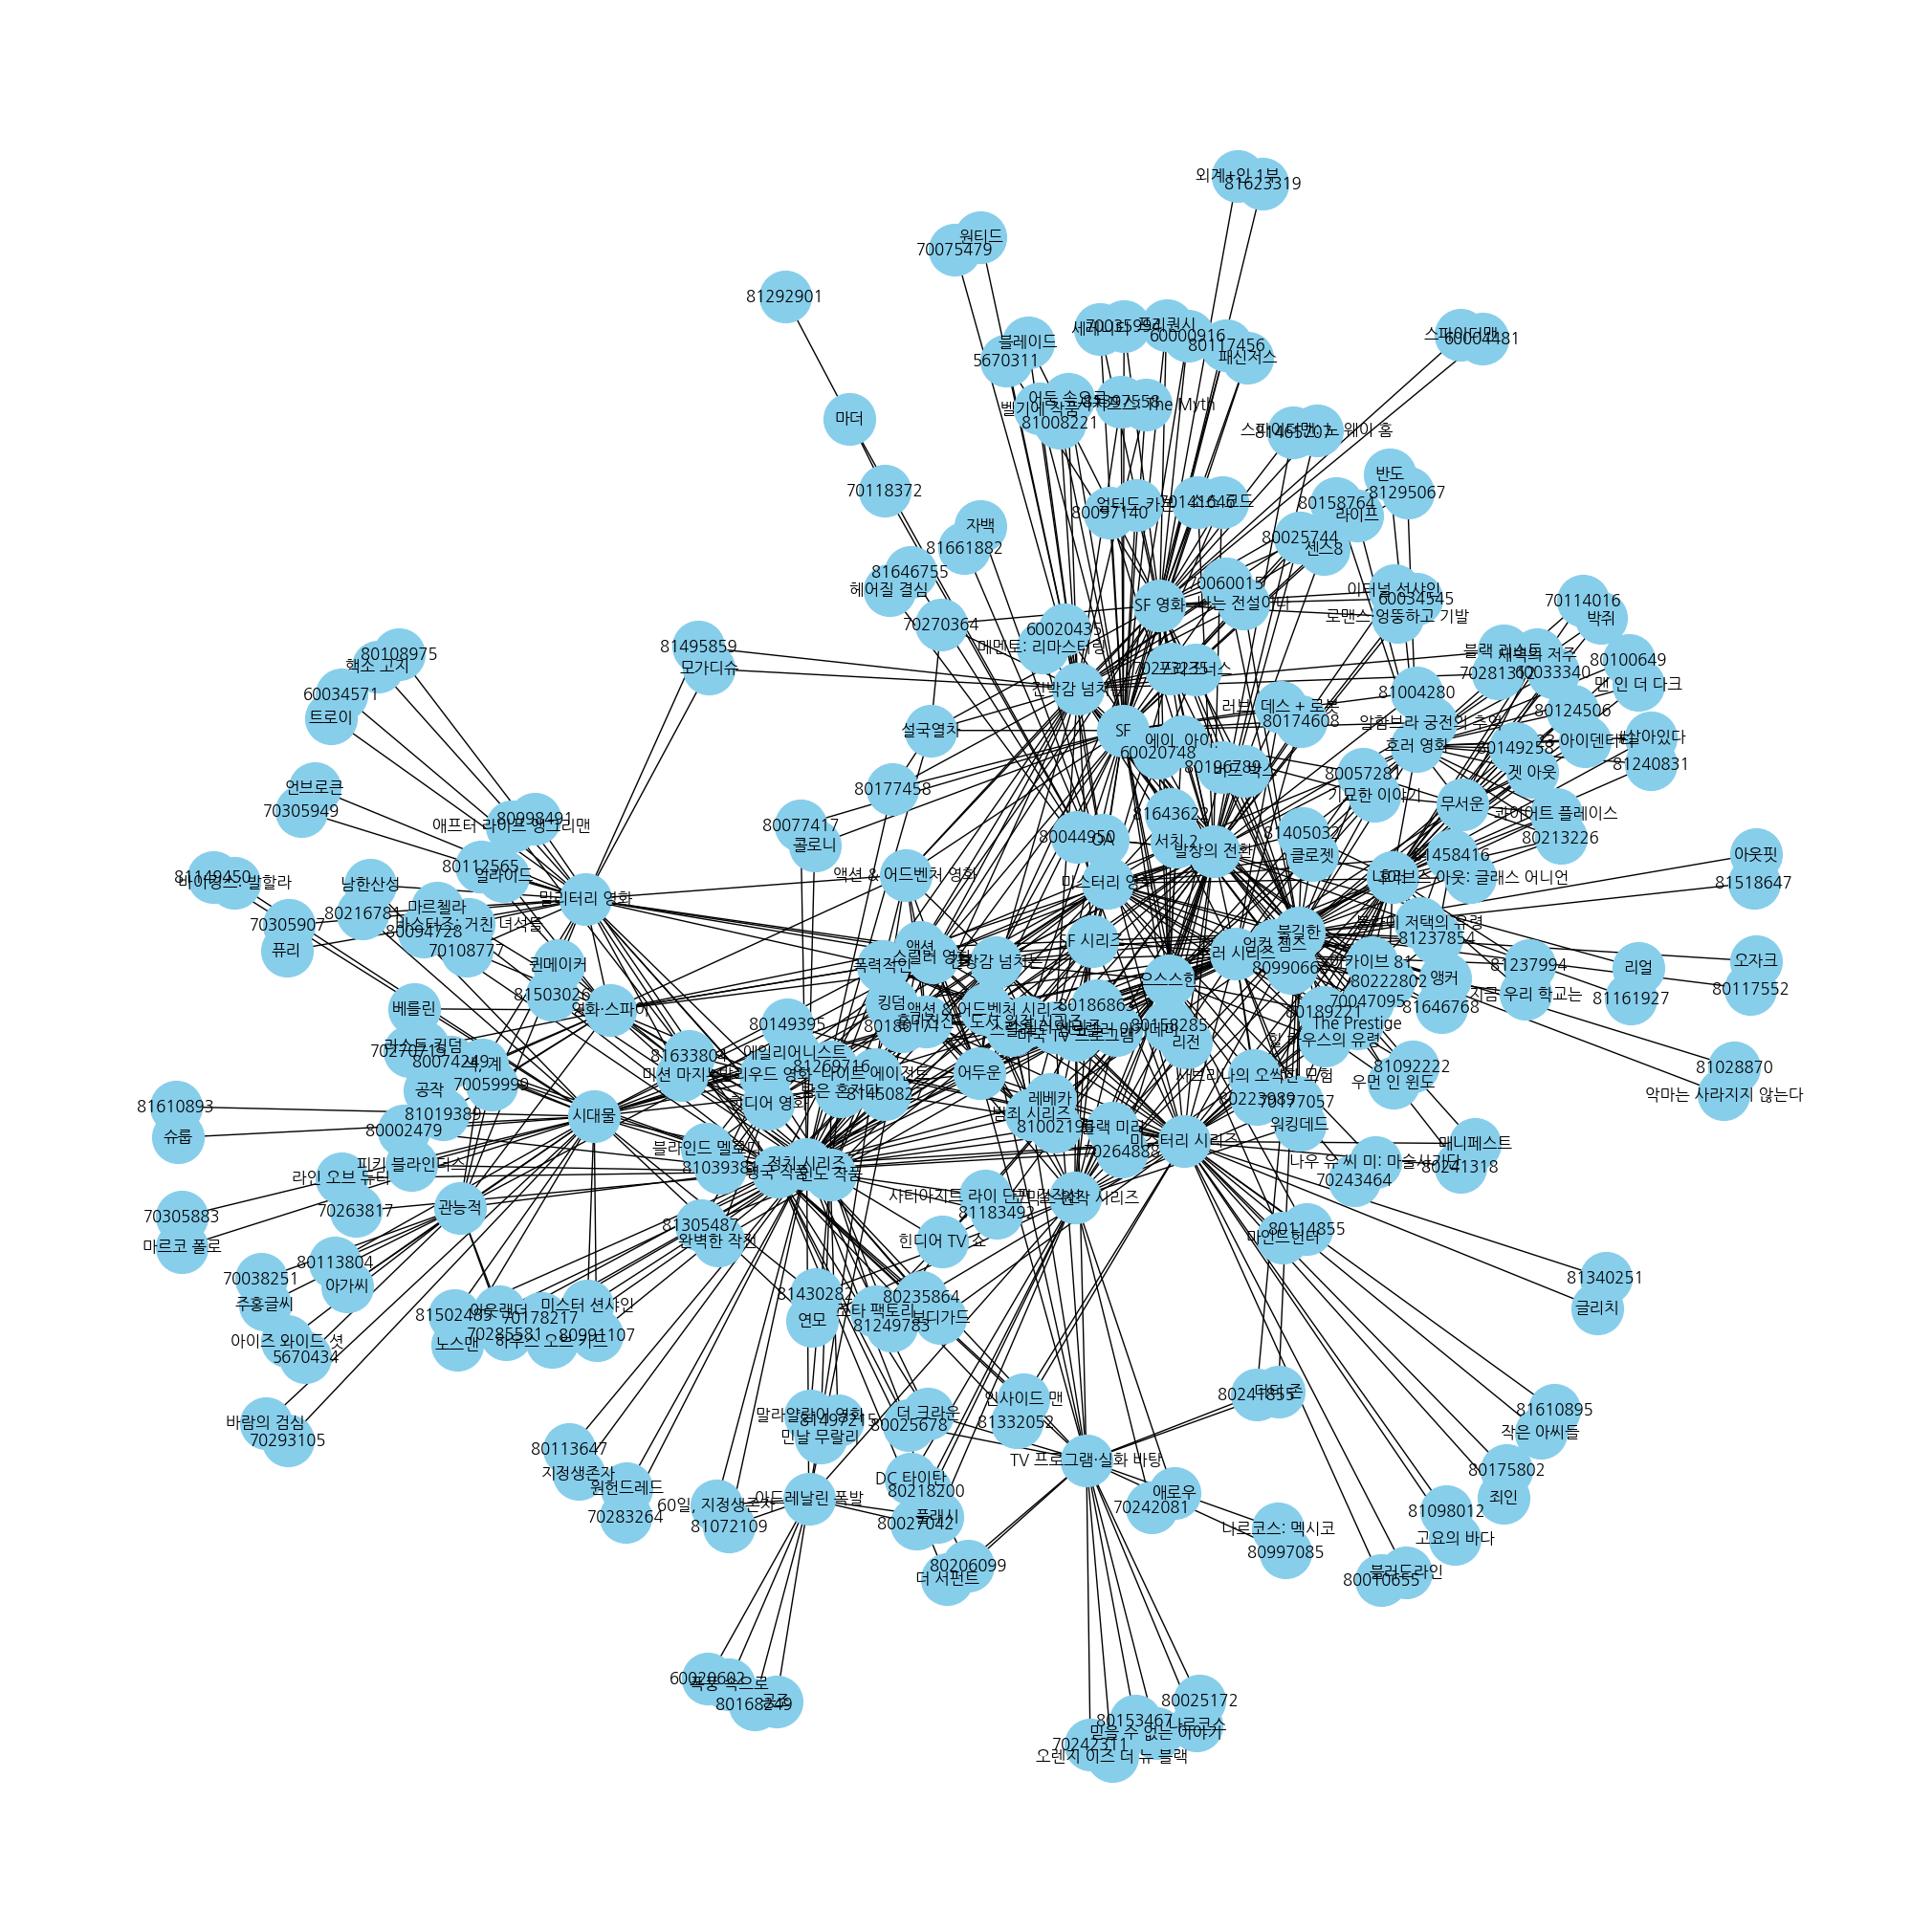

In [38]:
# isfp
gm.draw_community(fi1,nodes = c[c==c.loc["불길한"]].index)